In [1]:
import popsims
import numpy as np
import matplotlib.pyplot as plt
import wisps
import pandas as pd
import wisps.simulations as wispsim
from tqdm import tqdm 
import astropy.units as u
import numba
%matplotlib inline

/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [4]:
thin_points=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
names=[x.name for x in thin_points]
volumes=pd.read_pickle(wisps.OUTPUT_FILES+'/thick_disk_volumes.pkl')
DATA=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut_thick_disk.h5',\
     key=str('burrows1997')+'F110_corrected')
THIN_DATA=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut_binaries_updatedrelations.h5',
                       key=str('baraffe2003')+str(350)+str('spt_abs_mag'))
DISTS=pd.read_pickle(wisps.OUTPUT_FILES+'/thick_disk_distances.pkl')

In [5]:
tot_volumes=abs(np.nansum([[volumes[s][k] for k in  names] for s in wispsim.SPGRID], axis=1))

In [6]:
AREA=4.1*(u.arcmin**2).to(u.radian**2)

In [7]:
hidx=200
thin_volumes=np.nansum([[x.volumes[hidx][s] for x in thin_points] \
                            for s in wispsim.SPGRID], axis=1)

In [8]:
np.nanmedian([x.dist_limits[30][0] for x in thin_points])

279.7501137522345

In [9]:
pd.DataFrame.from_records([x.mag_limits for x in thin_points]).median()

F110    21.851789
F140    21.804624
F160    21.688738
dtype: float64

In [10]:
dict(zip(wispsim.SPGRID, np.log10(thin_volumes*AREA)))

{17: 3.7084371874632507,
 18: 3.6537170300539965,
 19: 3.6033932412722893,
 20: 3.5474246271851855,
 21: 3.477113934369873,
 22: 3.38822125062523,
 23: 3.281606231727107,
 24: 3.1629682289103678,
 25: 3.0441392167404353,
 26: 2.9377502014612475,
 27: 2.8561874791347286,
 28: 2.8061720001724786,
 29: 2.790074549305816,
 30: 2.8023465962640977,
 31: 2.8301244692732204,
 32: 2.8560817720106115,
 33: 2.8588375734531613,
 34: 2.8135653759369355,
 35: 2.6888952006154514,
 36: 2.4448065276720605,
 37: 2.03394663154228,
 38: 1.4089177720157762,
 39: 0.5405574198745623,
 40: -0.5687286449793876,
 41: -1.8837389551783026}

[None, Text(0, 0.5, 'volume (kpc$^3$)')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


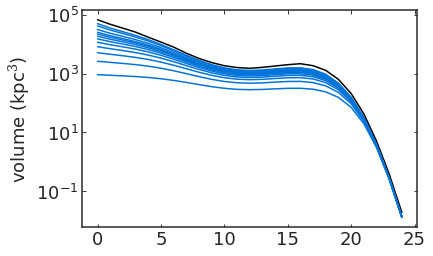

In [11]:
fig, ax=plt.subplots()
plt.plot(tot_volumes*AREA, color='k')
for hidx in thin_points[0].volumes.keys():
    thin_volumes=np.nansum([[x.volumes[hidx][s] for x in thin_points] \
                            for s in wispsim.SPGRID], axis=1)
    plt.plot(thin_volumes*AREA, color='#0074D9')
ax.set(yscale='log', ylabel=r'volume (kpc$^3$)')

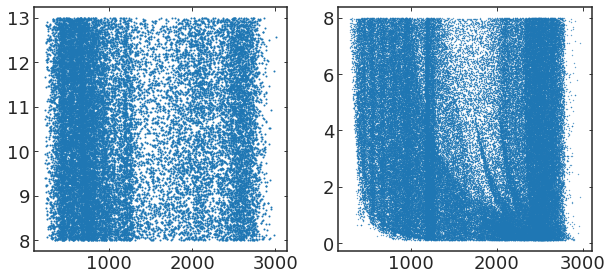

In [12]:
fig, ax=plt.subplots(ncols=2, figsize=(10, 4.5))

h_= ax[0].scatter(DATA.temperature.values, DATA.age.values,s=1)
h_= ax[1].scatter( THIN_DATA.temperature.values[~THIN_DATA.is_cut],\
                 THIN_DATA.age.values[~THIN_DATA.is_cut], s=.1)


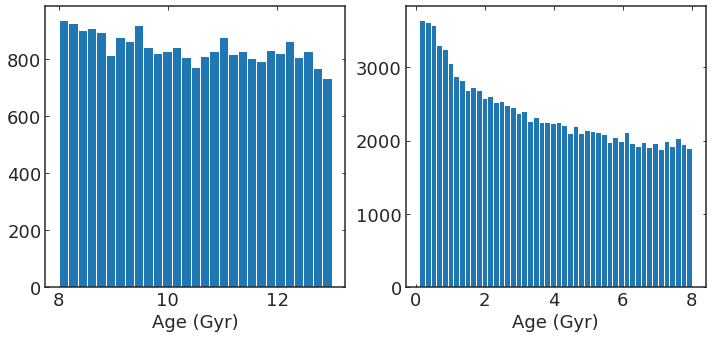

In [13]:
fig, ax=plt.subplots(ncols=2, figsize=(10, 4.5))
h_= ax[0].hist(DATA.age.values,  bins='auto')
h_= ax[1].hist( THIN_DATA.age.values[~THIN_DATA.is_cut],  bins='auto')
plt.tight_layout()
for a in ax:
    a.set(xlabel='Age (Gyr)')


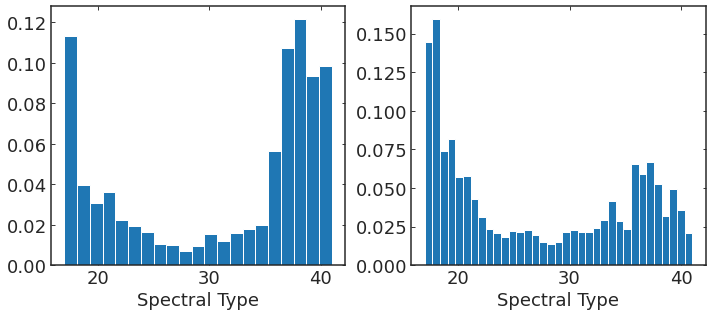

In [14]:
fig, ax=plt.subplots(ncols=2, figsize=(10, 4.5))
h_= ax[0].hist(DATA.spt.values,  bins='auto', density=True)
h_= ax[1].hist( THIN_DATA.spt.values[~THIN_DATA.is_cut],  bins='auto', density=True)
plt.tight_layout()
for a in ax:
    a.set(xlabel='Spectral Type')

plt.tight_layout()

In [15]:
 #THIN_DATA.columns

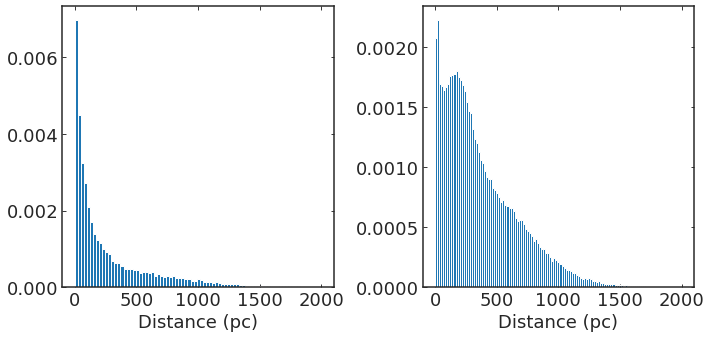

In [16]:
fig, ax=plt.subplots(ncols=2, figsize=(10, 4.5))
h_= ax[0].hist(DATA.dist.values,  bins='auto', density=True, range=[0,2000])
h_= ax[1].hist( THIN_DATA.dist.values[~THIN_DATA.is_cut],  bins='auto', density=True, \
               range=[0, 2000])
plt.tight_layout()

for a in ax:
    a.set(xlabel='Distance (pc)')


In [17]:
def get_simulated_number_model(df):
    cutdf=df.rename(columns={'temperature': 'teff', \
                                          'slprob': 'sl'})

    scale=[cutdf.scale.mean(), cutdf.scale_unc.mean(), cutdf.scale_times_model.mean()]
    
    NSIM=dict(zip(wispsim.SPGRID,np.zeros((len(wispsim.SPGRID), 2))))
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        sn= len(cutdf.teff[np.logical_and(cutdf.teff>=450, cutdf.teff<=2100)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        #scln=np.array(scale)
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].sl)*scln
    del cutdf
    return NSIM

def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

In [18]:
nexpct_dict=get_simulated_number_model(DATA)
tot_volumes_dict=dict(zip( wispsim.SPGRID, tot_volumes ))

In [19]:
nbers=np.array([nexpct_dict[k][0]*tot_volumes_dict[k]*AREA for k in wispsim.SPGRID])

In [20]:
dict(zip( wispsim.SPGRID, nbers))

{17: 88.1467728972917,
 18: 70.42217546848279,
 19: 21.302186499229634,
 20: 14.641004031886457,
 21: 11.898519368272051,
 22: 5.476962792850934,
 23: 2.9027958541375694,
 24: 1.6615913523580879,
 25: 0.7774901539327032,
 26: 0.412015008489994,
 27: 0.3292396043395582,
 28: 0.2155591700065583,
 29: 0.2619337804900325,
 30: 0.49818047495323714,
 31: 0.40577721834620706,
 32: 0.5122246036124194,
 33: 0.7233178859381504,
 34: 0.6292155701293336,
 35: 0.5340439122308777,
 36: 0.7691003672366934,
 37: 0.4250545423735626,
 38: 0.0956911709366208,
 39: 0.009160561019788934,
 40: 0.0001417584693457522,
 41: 0.0}

In [21]:
bin_by_spt_bin(wispsim.SPGRID, nbers)

[179.8711348650041,
 36.5808733995051,
 1.9962377172588461,
 2.7687157529793476,
 1.8330505537975432]

In [22]:
THIN_DATA.columns

Index(['mass', 'age', 'temperature', 'luminosity', 'is_binary', 'spt',
       'prim_spt', 'sec_spt', 'pri_mass', 'sec_mass', 'prim_luminosity',
       'sec_luminosity', 'scale', 'scale_unc', 'scale_times_model', 'dist',
       'pntname', 'pnt', 'exp_image', 'exp_grism', 'absF110', 'prim_absF110',
       'sec_absF110', 'appF110', 'appF110er', 'absF140', 'prim_absF140',
       'sec_absF140', 'appF140', 'appF140er', 'absF160', 'prim_absF160',
       'sec_absF160', 'appF160', 'appF160er', 'snrj110', 'snrj140', 'snrjs160',
       'snrj', 'slprob', 'is_cut'],
      dtype='object')

In [23]:
#len(tot_volumes), len(wispsim.SPGRID)

In [24]:
#np.nanstd(df.to_pandas().col65)

In [25]:
#np.nanmax(df.to_pandas().col65)

In [26]:
#np.nanmin(df.to_pandas().col65)

In [27]:
 avr_sharma([15, 16])

NameError: name 'avr_sharma' is not defined

In [ ]:
avr_sharma(0)